# SkimLit (Skim Literature)

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
import tensorflow as tf
print(tf.__version__)

2.9.2


## Downloading the data

In [94]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [95]:
# I will be using PubMed_20k_RCT_numbers_replaced_with_at_sign dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [96]:
# Checking all of the filenames in the target directory
import os

filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Data Preprocessing

In [97]:
def get_lines(filename):
    """
    Reads a text file and returns lines of text as a list.
    
    Args:
        filename: a string containing the target filepath to read.
  
    Returns:
        A list of strings with one string per line from the target filename.
        For example:
        ["this is the first line of filename",
        "this is the second line of filename",
        "..."]
    """
    
    with open(filename, 'r') as f:
        return f.readlines()

In [98]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [99]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number
    the target line is.

    Args:
    filename: a string of the target text file to read and extract line data
    from.

    Returns:
    A list of dictionaries each containing a line from an abstract,
    the lines label, the lines position in the abstract and the total number
    of lines in the abstract where the line is from. For example:

    [{"target": 'CONCLUSION',
    "text": The study couldn't have gone better, turns out people are kinder than you think",
    "line_number": 8,
    "total_lines": 8}]
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return abstract_samples

In [100]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [101]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [102]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [103]:
# Converting abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences)

(180040, 30212)

In [104]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [105]:
# One-Hot encoded labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [106]:
# Integer encoded labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [107]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling

### Model 0: Naive Bayes (Baseline model)

#### Fitting the model

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
                      y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [109]:
model_0.score(X=val_sentences,
                        y=val_labels_encoded)

0.7218323844829869

In [110]:
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [111]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
    Returns a dictionary of accuracy, precision, recall, f1-score.
    """

    model_accuracy = accuracy_score(y_true, y_pred) * 100

    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [112]:
model_0_results = calculate_results(val_labels_encoded,
                                        model_0_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing data for deep sequence models

In [113]:
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [114]:
# average length of sentences
len_sent = [len(sentence.split()) for sentence in train_sentences]
avg_len_sent = np.average(len_sent)
avg_len_sent

26.338269273494777

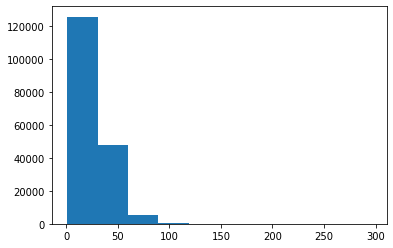

In [115]:
plt.hist(len_sent);

In [116]:
# finding a length which can cover 95% of sentences
output_seq_len = int(np.percentile(len_sent, 95))
output_seq_len

55

#### Creating token embedding

In [117]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Vocabulary size
max_tokens = 68000

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [118]:
text_vectorizer.adapt(train_sentences)

In [119]:
# testing our text vectorizer
import random 

target_sentence = random.choice(train_sentences)
print(f"Before text vectoriztion: \n{target_sentence}\n")
print(f"Length of text: {len(target_sentence.split())}\n")
print(f"After text vectorization: \n{text_vectorizer(target_sentence)}")

Before text vectoriztion: 
we prospectively enrolled patients undergoing laparoscopic colorectal surgery aged over @ years between @ and @ .

Length of text: 17

After text vectorization: 
[  43 1125  230   12  295  723 1264  115  307  145   64   30    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [120]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [121]:
# Creating token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
we prospectively enrolled patients undergoing laparoscopic colorectal surgery aged over @ years between @ and @ .

Sentence after vectorization (before embedding):
[[  43 1125  230   12  295  723 1264  115  307  145   64   30    3    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.00293273 -0.04063113  0.00456661 ... -0.03583372 -0.01516559
    0.02397574]
  [-0.0469651   0.03108766 -0.00502664 ... -0.03910945 -0.01582655
    0.02776888]
  [-0.04361832 -0.02771562 -0.00011815 ...  0.02411637 -0.04417061
    0.00313269]
  ...
  [-0.04398667 -0.03792719 -0.04496811 ... -0.00175982  0.00180334
   -0.02935374]
  [-0.04398667 -0.03792719 -0.04496811 ... -0.00175982  0.00180334
   -0.02935374]
  [-0.04398667 -0.03792719 -0.04496811 ... -0.00175982  0.00180334
   -0

In [122]:
# turning the data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Creating Callbacks

In [123]:
tensorboard_dir = "drive/MyDrive/SkimLit/training_logs"
checkpoint_dir = "drive/MyDrive/SkimLit/checkpoints"
os.makedirs(tensorboard_dir)
os.makedirs(checkpoint_dir)

In [124]:
import datetime

def tensorboard_callback(experiment_name):
    """
    Creates a TensorBoard callback instance to store log files.
    
    Stores log files with the filepath:
        "dir_name/experiment_name/current_datetime/"
    """
    log_dir = "drive/MyDrive/SkimLit/training_logs/" + experiment_name 
    os.makedirs(log_dir)
    log_dir += "/" + datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
    
    return tensorboard_callback

def checkpoint_callback(dir_name):
    checkpoint_path = "drive/MyDrive/SkimLit/checkpoints/"+ dir_name +"/"
    os.makedirs(checkpoint_path)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                          monitor="val_accuracy",
                                                          save_weights_only=True,
                                                          save_best_only=True)
    return model_checkpoint

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.1,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

### Model 1: Conv1D with token embeddings

#### Constructing the model

In [125]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [126]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_4 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 5)                 325 

#### Fitting the model

In [127]:
model_1_history = model_1.fit(train_dataset,
                              epochs=20,
                              steps_per_epoch=len(train_dataset),
                              validation_data=val_dataset,
                              validation_steps=int(0.5 * len(val_dataset)),
                              callbacks=[tensorboard_callback("Conv1D_token_embed"),
                                         checkpoint_callback("Conv1D_token_embed"),
                                         early_stopping,
                                         reduce_lr])

Epoch 1/20
5627/5627 [==============================] - 48s 8ms/step - loss: 0.7945 - accuracy: 0.7089 - val_loss: 0.5469 - val_accuracy: 0.7992 - lr: 1.0000e-04
Epoch 2/20
5627/5627 [==============================] - 46s 8ms/step - loss: 0.5105 - accuracy: 0.8160 - val_loss: 0.4916 - val_accuracy: 0.8165 - lr: 1.0000e-04
Epoch 3/20
5627/5627 [==============================] - 45s 8ms/step - loss: 0.4482 - accuracy: 0.8400 - val_loss: 0.4727 - val_accuracy: 0.8224 - lr: 1.0000e-04
Epoch 4/20
5627/5627 [==============================] - 45s 8ms/step - loss: 0.4045 - accuracy: 0.8565 - val_loss: 0.4649 - val_accuracy: 0.8251 - lr: 1.0000e-04
Epoch 5/20
5627/5627 [==============================] - 45s 8ms/step - loss: 0.3670 - accuracy: 0.8709 - val_loss: 0.4636 - val_accuracy: 0.8277 - lr: 1.0000e-04
Epoch 6/20
5627/5627 [==============================] - 47s 8ms/step - loss: 0.3321 - accuracy: 0.8852 - val_loss: 0.4665 - val_accuracy: 0.8279 - lr: 1.0000e-04
Epoch 7/20
5627/5627 [======

In [128]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4849 - accuracy: 0.8252


[0.48487183451652527, 0.825168788433075]

In [129]:
model_1_preds = tf.argmax(model_1.predict(val_dataset), axis=1)
model_1_preds

945/945 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [130]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 82.5168807096518,
 'precision': 0.8247619426213408,
 'recall': 0.825168807096518,
 'f1': 0.8234236163470768}

In [131]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-16 20:31:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-16 20:31:39 (103 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



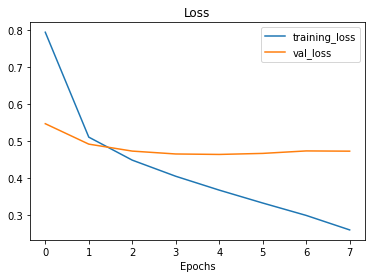

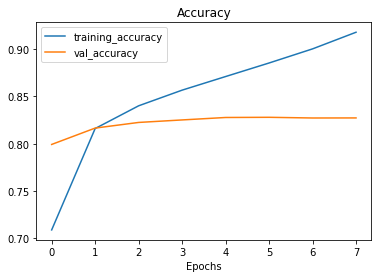

In [132]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_1_history)

In [133]:
save_dir = "drive/MyDrive/SkimLit/saved_models/Conv1D_token_embed"
os.makedirs(save_dir)

model_1.save(save_dir)

### Model 2: Combination of pretrained token embeddings + character embeddings 

#### Creating pretrained token embedding 

In [134]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [135]:
# Testing out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
concern in terms of quality and feelings of well-being after @ and @ months , was observed significant difference compared with before using .

Sentence after embedding:
[ 0.00827744 -0.04200996 -0.04626331 -0.05978069 -0.01466626  0.03201189
  0.03532061 -0.02845569  0.03415912  0.06369494  0.01474843  0.07971609
 -0.06964759  0.00052215  0.03766633  0.02400964 -0.07492597 -0.00324929
  0.01146897  0.01322796  0.06372016  0.06402435  0.01476215  0.03816341
 -0.02659592  0.03671021  0.00066402  0.05702707 -0.03601167 -0.02339731] (truncated output)...

Length of sentence embedding:
512


#### Creating character level tokenizer

In [136]:
# function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

split_chars(random_training_sentence)

'c o n c e r n   i n   t e r m s   o f   q u a l i t y   a n d   f e e l i n g s   o f   w e l l - b e i n g   a f t e r   @   a n d   @   m o n t h s   ,   w a s   o b s e r v e d   s i g n i f i c a n t   d i f f e r e n c e   c o m p a r e d   w i t h   b e f o r e   u s i n g   .'

In [200]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [138]:
# Combining word and character data into tensorflow dataset
train_word_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_word_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_word_char_dataset = tf.data.Dataset.zip((train_word_char_data, train_word_char_labels))
train_word_char_dataset = train_word_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_word_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_word_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_word_char_dataset = tf.data.Dataset.zip((val_word_char_data, val_word_char_labels))
val_word_char_dataset = val_word_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [139]:
train_word_char_dataset, val_word_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [140]:
char_lens = [len(sentence) for sentence in train_sentences]
avg_char_len = np.average(char_lens)
avg_char_len

149.3662574983337

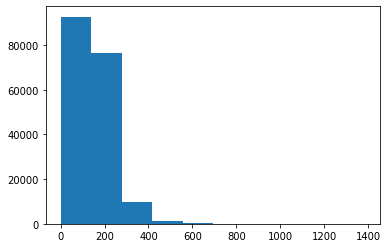

In [141]:
plt.hist(char_lens);

In [142]:
output_char_seq_len = int(np.percentile(char_lens, 95))
output_char_seq_len

290

In [143]:
# Get all keyboard characters for char-level embedding
import string
char_tokens = string.ascii_lowercase + string.digits + string.punctuation
char_tokens

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [144]:
NUM_CHAR_TOKENS = len(char_tokens) + 2 # num characters in char_tokens + space + UNK token

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_char_seq_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [145]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [146]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   n g   p a t c h   i s   a   m o r e   e f f e c t i v e   m e t h o d   f o r   p r e t e r m   l a b o r   c o n t r o l   t h a n   n i f e d i p i n e   w i t h   r e g a r d   t o   m i n i m a l   s i d e   e f f e c t s   .

Length of chars: 99

Vectorized chars:
[[ 3 13  2  6 18 14  5  3 11 13  4  9  5 15  7  8  2  2 17 17  2 11  3  4
  21  2 15  2  3 13  7 10 17  7  8 14  8  2  3  2  8 15 12  5 22  7  8 11
   7  6  3  8  7 12  3 13  5  6  6  4 17  2 10  4 14  4  6  2 20  4  3 13
   8  2 18  5  8 10  3  7 15  4  6  4 15  5 12  9  4 10  2  2 17 17  2 11
   3  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0

#### Creating character-level embedding

In [147]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              name="char_embed")

print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   n g   p a t c h   i s   a   m o r e   e f f e c t i v e   m e t h o d   f o r   p r e t e r m   l a b o r   c o n t r o l   t h a n   n i f e d i p i n e   w i t h   r e g a r d   t o   m i n i m a l   s i d e   e f f e c t s   .

Embedded chars (after vectorization and embedding):
[[[-0.02399691  0.03040781 -0.04595509 ... -0.01349342 -0.03175901
    0.04634906]
  [-0.04321984 -0.01083423 -0.04314941 ...  0.01917939 -0.01036701
   -0.00069605]
  [ 0.03367067  0.03859825  0.04297921 ... -0.03869845  0.00168444
    0.00822886]
  ...
  [-0.00512228  0.02097002  0.04510066 ... -0.03222541 -0.03286052
   -0.04736063]
  [-0.00512228  0.02097002  0.04510066 ... -0.03222541 -0.03286052
   -0.04736063]
  [-0.00512228  0.02097002  0.04510066 ... -0.03222541 -0.03286052
   -0.04736063]]]

Character embedding shape: (1, 290, 25)


#### Constructing the model

In [148]:
# Setup word inputs
word_inputs = layers.Input(shape=[], dtype=tf.string, name="word_input")
word_embeddings = tf_hub_embedding_layer(word_inputs)
word_output = layers.Dense(128, activation="relu")(word_embeddings)
word_model = tf.keras.Model(inputs=word_inputs, 
                            outputs=word_output)

# Setup char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Concatenate word and char inputs
word_char_concat = layers.Concatenate(name="word_char_concat")([word_model.output,
                                                                char_model.output])

# Dropout and output layers
combined_dropout = layers.Dropout(0.5)(word_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_2 = tf.keras.Model(inputs=[word_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_2_word_and_char_embedding")

In [149]:
model_2.summary()

Model: "model_2_word_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 word_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['w

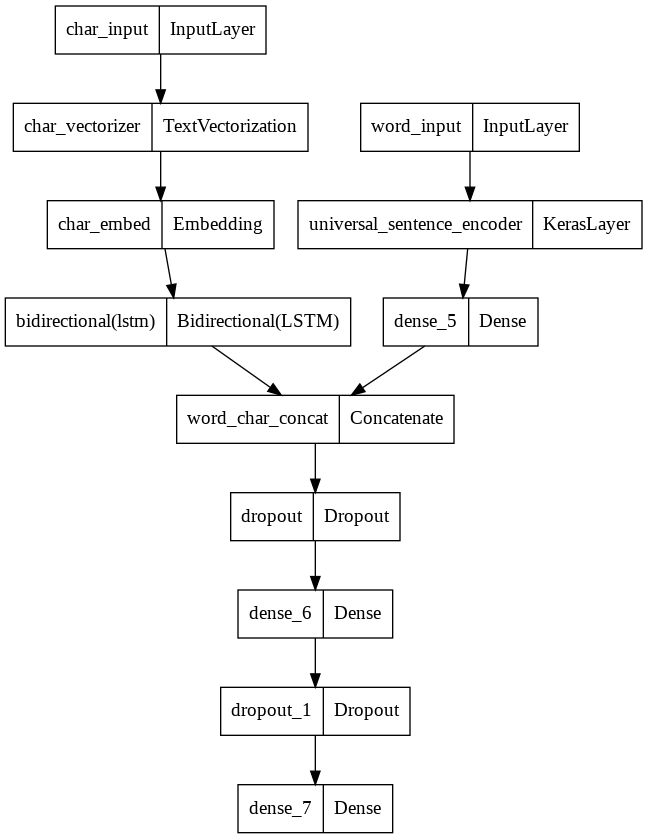

In [150]:
from tensorflow.keras.utils import plot_model
plot_model(model_2)

In [151]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Fitting the model

In [152]:
model_2_history = model_2.fit(train_word_char_dataset,
                              steps_per_epoch=len(train_word_char_dataset),
                              epochs=20,
                              validation_data=val_word_char_dataset,
                              validation_steps=int(0.5 * len(val_word_char_dataset)),
                              callbacks=[tensorboard_callback("char_pretrained_word_embedding"),
                                         checkpoint_callback("char_pretrained_word_embedding"),
                                         early_stopping,
                                         reduce_lr])

Epoch 1/20
5627/5627 [==============================] - 209s 36ms/step - loss: 0.7601 - accuracy: 0.7083 - val_loss: 0.6332 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 2/20
5627/5627 [==============================] - 202s 36ms/step - loss: 0.6819 - accuracy: 0.7417 - val_loss: 0.6059 - val_accuracy: 0.7686 - lr: 0.0010
Epoch 3/20
5627/5627 [==============================] - 201s 36ms/step - loss: 0.6598 - accuracy: 0.7497 - val_loss: 0.5909 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 4/20
5627/5627 [==============================] - 210s 37ms/step - loss: 0.6428 - accuracy: 0.7581 - val_loss: 0.5818 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 5/20
5627/5627 [==============================] - 194s 35ms/step - loss: 0.6312 - accuracy: 0.7618 - val_loss: 0.5791 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 6/20
5627/5627 [==============================] - 194s 35ms/step - loss: 0.6234 - accuracy: 0.7650 - val_loss: 0.5652 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 7/20
5627/5627 [==================

In [153]:
model_2.load_weights("drive/MyDrive/SkimLit/checkpoints/char_pretrained_word_embedding/")

In [154]:
model_2.evaluate(val_word_char_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.5343 - accuracy: 0.8003


[0.5343296527862549, 0.8003111481666565]

In [155]:
model_2_preds = tf.argmax(model_2.predict(val_word_char_dataset), axis=1)
model_2_preds

945/945 [==============================] - 21s 21ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [156]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 80.0311134648484,
 'precision': 0.8006926556596292,
 'recall': 0.800311134648484,
 'f1': 0.7965291608073933}

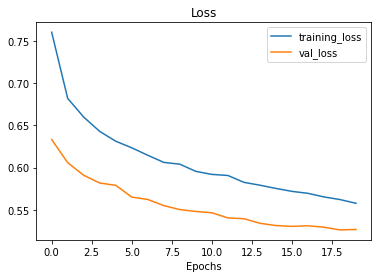

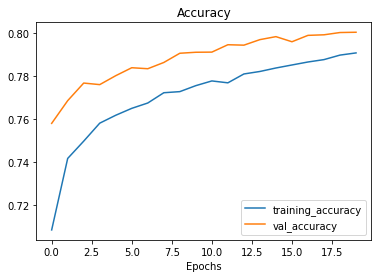

In [157]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_2_history)

In [158]:
save_dir = "drive/MyDrive/SkimLit/saved_models/char_pretrained_word_embedding"
os.makedirs(save_dir)

model_2.save(save_dir)

### Model 3: Combination of pretrained token embeddings, character embeddings and positional embeddings

#### Creating positional embeddings

In [159]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [160]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

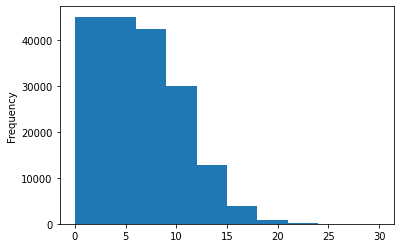

In [161]:
train_df.line_number.plot.hist();

In [201]:
# Using TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [163]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [164]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

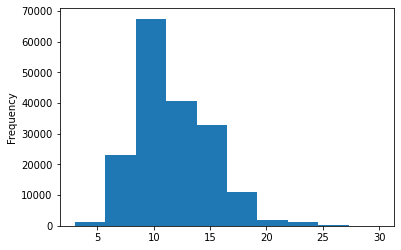

In [165]:
train_df.total_lines.plot.hist();

In [166]:
np.percentile(train_df.total_lines, 98)

20.0

In [202]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

#### Constructing the model

In [168]:
# Setup word inputs
word_inputs = layers.Input(shape=[], dtype=tf.string, name="word_input")
word_embeddings = tf_hub_embedding_layer(word_inputs)
word_output = layers.Dense(128, activation="relu")(word_embeddings)
word_model = tf.keras.Model(inputs=word_inputs, 
                            outputs=word_output)

# Setup char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# Concatenate word and char inputs
word_char_concat = layers.Concatenate(name="word_char_concat")([word_model.output,
                                                                char_model.output])

z = layers.Dense(256, activation="relu")(word_char_concat)
z = layers.Dropout(0.5)(z)

# Concatenate positional embeddings with word and char embeddings
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(z)

model_3 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 word_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [169]:
model_3.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 word_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['word_input[0][0]']      

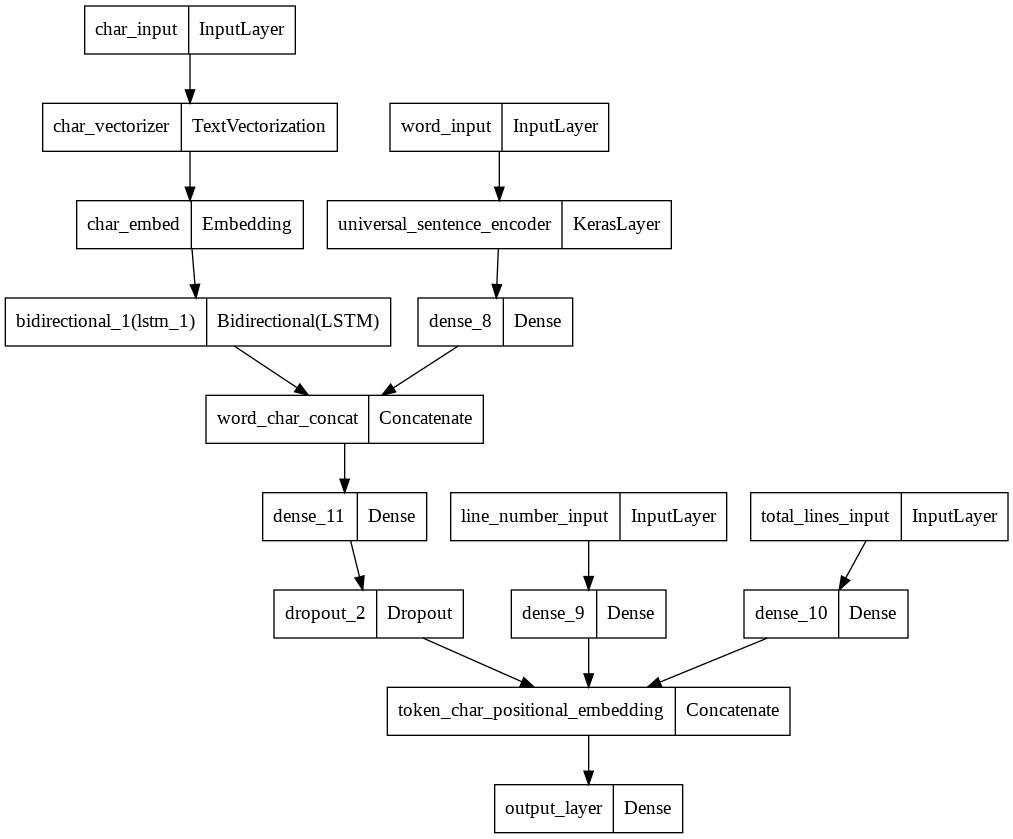

In [170]:
from tensorflow.keras.utils import plot_model
plot_model(model_3)

In [171]:
for layer in model_3.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5af1457c40> True
<keras.engine.input_layer.InputLayer object at 0x7f5af14577f0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f5a360d0df0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f5b5e752a60> False
<keras.layers.core.embedding.Embedding object at 0x7f5a360ebee0> True
<keras.layers.core.dense.Dense object at 0x7f5af1457d60> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7f5af15a7730> True
<keras.layers.merging.concatenate.Concatenate object at 0x7f5af15b2fa0> True
<keras.engine.input_layer.InputLayer object at 0x7f5b5eff0310> True
<keras.engine.input_layer.InputLayer object at 0x7f5aef740d90> True
<keras.layers.core.dense.Dense object at 0x7f5af15b29d0> True
<keras.layers.core.dense.Dense object at 0x7f5aef1a4d30> True
<keras.layers.core.dense.Dense object at 0x7f5aef1d9580> True
<keras.layers.regularization.dropout.Dropout object at 0x7f5aee785160> True
<keras.layers

In [172]:
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [173]:
train_pos_char_word_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_word_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_word_dataset = tf.data.Dataset.zip((train_pos_char_word_data, train_pos_char_word_labels))
train_pos_char_word_dataset = train_pos_char_word_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_pos_char_word_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_word_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_word_dataset = tf.data.Dataset.zip((val_pos_char_word_data, val_pos_char_word_labels))
val_pos_char_word_dataset = val_pos_char_word_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_word_dataset, val_pos_char_word_dataset     

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fitting the model

In [174]:
model_3_history = model_3.fit(train_pos_char_word_dataset,
                              steps_per_epoch=len(train_pos_char_word_dataset),
                              epochs=20,
                              validation_data=val_pos_char_word_dataset,
                              validation_steps=int(0.5 * len(val_pos_char_word_dataset)),
                              callbacks=[tensorboard_callback("char_pretrained_word_positional_embedding"),
                                         checkpoint_callback("char_pretrained_word_positional_embedding"),
                                         early_stopping,
                                         reduce_lr])

Epoch 1/20
5627/5627 [==============================] - 194s 34ms/step - loss: 0.9536 - accuracy: 0.8234 - val_loss: 0.9074 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 2/20
5627/5627 [==============================] - 187s 33ms/step - loss: 0.9085 - accuracy: 0.8542 - val_loss: 0.8976 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 3/20
5627/5627 [==============================] - 184s 33ms/step - loss: 0.8958 - accuracy: 0.8629 - val_loss: 0.8956 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 4/20
5627/5627 [==============================] - 186s 33ms/step - loss: 0.8861 - accuracy: 0.8705 - val_loss: 0.8921 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 5/20
5627/5627 [==============================] - 185s 33ms/step - loss: 0.8793 - accuracy: 0.8752 - val_loss: 0.8934 - val_accuracy: 0.8548 - lr: 0.0010
Epoch 6/20
5626/5627 [============================>.] - ETA: 0s - loss: 0.8748 - accuracy: 0.8791
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5627/5627 [==============

In [176]:
model_3.evaluate(val_pos_char_word_dataset)

945/945 [==============================] - 19s 21ms/step - loss: 0.8857 - accuracy: 0.8625


[0.8857336044311523, 0.8625380396842957]

In [177]:
model_3_preds = tf.argmax(model_3.predict(val_pos_char_word_dataset), axis=1)
model_3_preds

945/945 [==============================] - 20s 20ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [178]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 86.25380643452932,
 'precision': 0.8628223510315828,
 'recall': 0.8625380643452932,
 'f1': 0.8603659294175826}

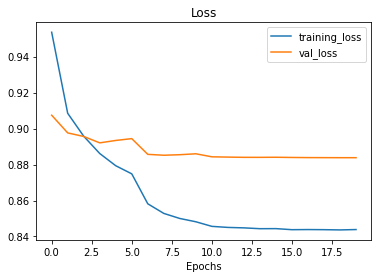

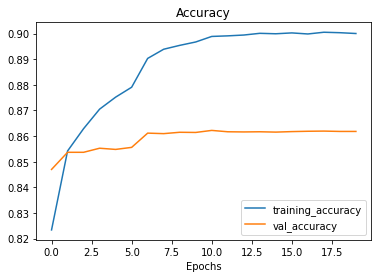

In [179]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_3_history)

In [180]:
save_dir = "drive/MyDrive/SkimLit/saved_models/char_pretrained_word_positional_embedding"
os.makedirs(save_dir)

model_3.save(save_dir)

### Model 4: Combination of Conv1D token embeddings, character embeddings and positional embeddings

#### Constructing the Model

In [181]:
# Setup word inputs
word_inputs = layers.Input(shape=(1,), dtype=tf.string, name="word_input")
text_vectors = text_vectorizer(word_inputs)
word_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(word_embeddings)
word_output = layers.GlobalMaxPooling1D()(x)
word_model = tf.keras.Model(inputs=word_inputs, 
                            outputs=word_output)

# Setup char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# Concatenate word and char inputs
word_char_concat = layers.Concatenate(name="word_char_concat")([word_model.output,
                                                                char_model.output])

z = layers.Dense(256, activation="relu")(word_char_concat)
z = layers.Dropout(0.5)(z)

# Concatenate positional embeddings with word and char embeddings
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(z)

model_4 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 word_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [182]:
model_4.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_2 (TextVect  (None, 55)          0           ['word_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_embedding (Embedding)    (None, 55, 128)      8299648     ['text_vectorization_2[1][

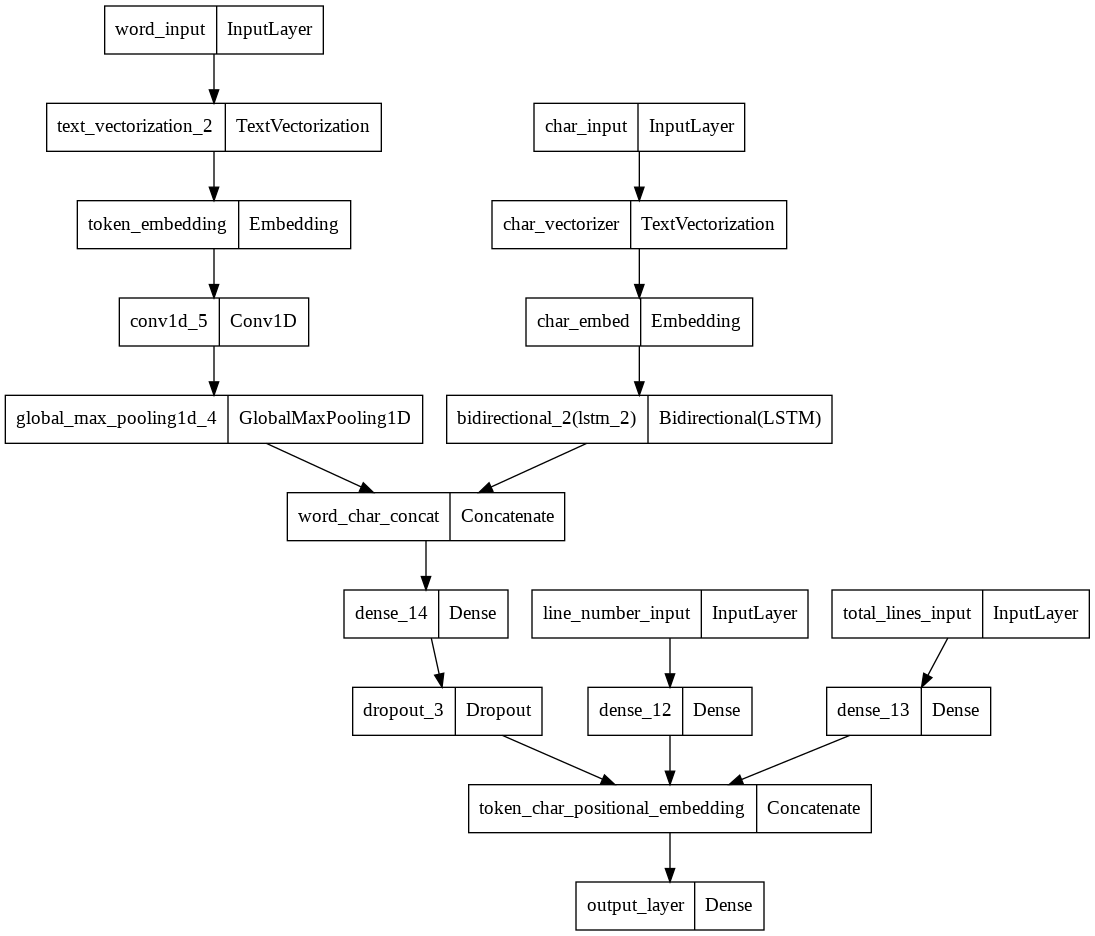

In [183]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [184]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Fitting the model

In [185]:
model_4_history = model_4.fit(train_pos_char_word_dataset,
                              steps_per_epoch=len(train_pos_char_word_dataset),
                              epochs=20,
                              validation_data=val_pos_char_word_dataset,
                              validation_steps=int(0.5 * len(val_pos_char_word_dataset)),
                              callbacks=[tensorboard_callback("char_word_positional_embedding"),
                                         checkpoint_callback("char_word_positional_embedding"),
                                         early_stopping,
                                         reduce_lr])

Epoch 1/20
5627/5627 [==============================] - 161s 28ms/step - loss: 0.8874 - accuracy: 0.8716 - val_loss: 0.8786 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 2/20
5627/5627 [==============================] - 160s 29ms/step - loss: 0.8208 - accuracy: 0.9187 - val_loss: 0.8894 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 3/20
5627/5627 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.9535
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5627/5627 [==============================] - 155s 28ms/step - loss: 0.7750 - accuracy: 0.9535 - val_loss: 0.9126 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 4/20
5627/5627 [==============================] - 150s 27ms/step - loss: 0.7370 - accuracy: 0.9769 - val_loss: 0.8949 - val_accuracy: 0.8612 - lr: 1.0000e-04


In [190]:
model_4.load_weights("drive/MyDrive/SkimLit/checkpoints/char_word_positional_embedding/")
model_4.evaluate(val_pos_char_word_dataset)

945/945 [==============================] - 12s 12ms/step - loss: 0.8818 - accuracy: 0.8648


[0.8818206787109375, 0.864788830280304]

In [191]:
model_4_preds = tf.argmax(model_4.predict(val_pos_char_word_dataset), axis=1)
model_4_preds

945/945 [==============================] - 11s 11ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [192]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 86.47888256321991,
 'precision': 0.8682951440380354,
 'recall': 0.8647888256321992,
 'f1': 0.8615915277315848}

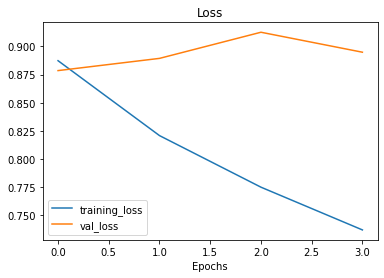

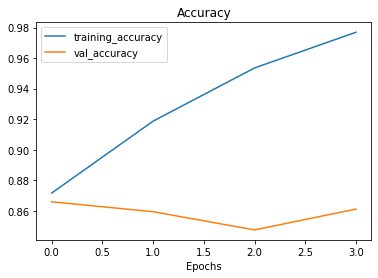

In [193]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_4_history)

In [194]:
save_dir = "drive/MyDrive/SkimLit/saved_models/char_word_positional_embedding"
os.makedirs(save_dir)

model_4.save(save_dir)

## Comparing Results

In [195]:
all_model_results = pd.DataFrame({"baseline": model_0_results,
                                  "Conv1D_token_embed": model_1_results,
                                  "char_pretrained_word_embedding": model_2_results,
                                  "char_pretrained_word_positional_embedding": model_3_results,
                                  "char_word_positional_embedding": model_4_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
Conv1D_token_embed,82.516881,0.824762,0.825169,0.823424
char_pretrained_word_embedding,80.031113,0.800693,0.800311,0.796529
char_pretrained_word_positional_embedding,86.253806,0.862822,0.862538,0.860366
char_word_positional_embedding,86.478883,0.868295,0.864789,0.861592


In [196]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

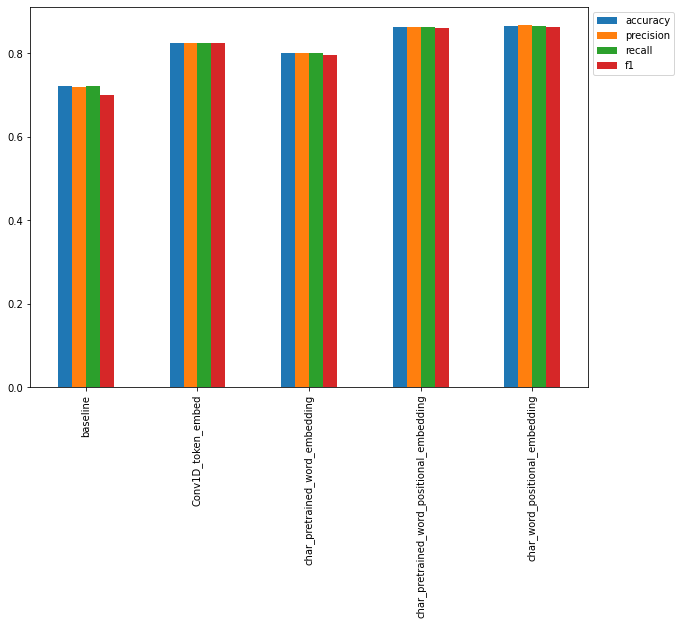

In [197]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

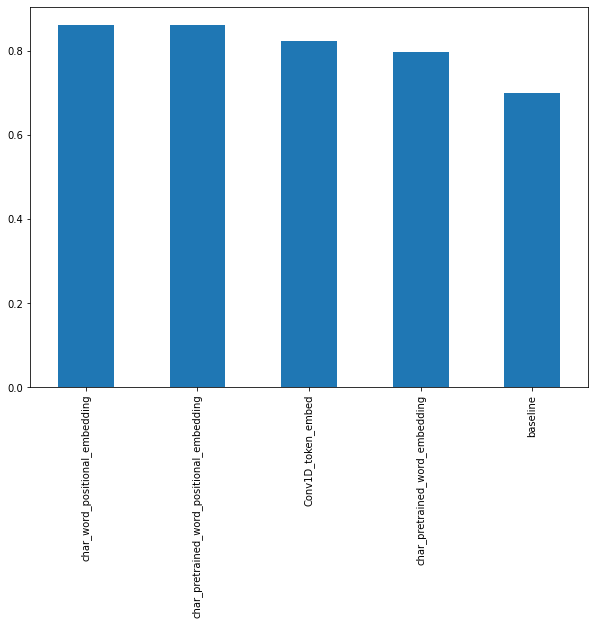

In [198]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Evaluating 2 best models on test dataset

In [203]:
test_pos_char_word_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_word_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_word_dataset = tf.data.Dataset.zip((test_pos_char_word_data, test_pos_char_word_labels))
test_pos_char_word_dataset = test_pos_char_word_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_word_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [206]:
test_pred_probs = model_4.predict(test_pos_char_word_dataset,
                                  verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 14s 15ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([4, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [207]:
model_4_test_results = calculate_results(y_true=test_labels_encoded,
                                         y_pred=test_preds)
model_4_test_results

{'accuracy': 85.97975775676124,
 'precision': 0.8619649591680605,
 'recall': 0.8597975775676124,
 'f1': 0.8560824474913552}

In [208]:
test_pred_probs = model_3.predict(test_pos_char_word_dataset,
                                  verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

model_3_test_results = calculate_results(y_true=test_labels_encoded,
                                         y_pred=test_preds)
model_3_test_results

942/942 [==============================] - 19s 20ms/step


{'accuracy': 85.88684254189481,
 'precision': 0.8591401414120157,
 'recall': 0.858868425418948,
 'f1': 0.856180533285835}

## Viewing Training results on Tensorboard

https://tensorboard.dev/experiment/SEn1rZGlSvKtVwjlZIexlQ/#scalars

In [ ]:
!tensorboard dev upload --logdir ./drive/MyDrive/SkimLit/training_logs \
   --name "SkimLit Models" \
   --description "Training results for different models" \
   --one_shot